In [1]:
import os
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show
from pathlib import Path
from pprint import pprint
import geemap

In [2]:
import ee
import geemap.core as geemap_core

# to register for google earth engine, create service account and set role of the service account
# https://developers.google.com/earth-engine/guides/access
service_account = 'google-earth-engine@tuwien-soil-roughness.iam.gserviceaccount.com'
credentials = ee.ServiceAccountCredentials(service_account, './tuwien-soil-roughness-04a0b908b35c.json')
ee.Initialize(credentials)

In [3]:
from geemap.common import download_ee_image
import pyproj

In [4]:
image_path = Path('/data/soil_roughness/SIG0-ROI-4580030-1334708-4684421-1362975\SIG0-ROI-4580030-1334708-4684421-1362975\V1M0R1\EQUI7_EU020M\E045N012T3'.replace('\\', '/'))
tif_file = 'SIG0-ROI-4580030-1334708-4684421-1362975_20170103T053523__VV_D066_E045N012T3_EU020M_V1M1R1_S1AIWGRDH_TUWIEN.tif'

In [5]:
tif_file_path = str(image_path / tif_file)

(4580030.0, 1362970.0)


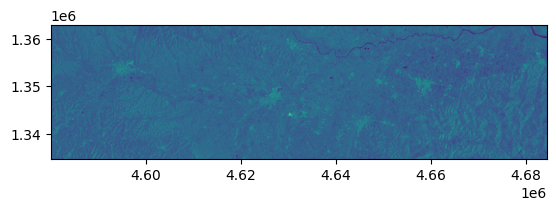

In [6]:
with rasterio.open(tif_file_path, GEOREF_SOURCES='INTERNAL') as src:
    bbox = src.bounds
    crs = src.read_crs()
    profile = src.profile
    print(src.xy(0,0))
    plt.imshow(src.read(1))
    show(src)

In [7]:
crs

CRS.from_wkt('PROJCS["unknown",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Azimuthal_Equidistant"],PARAMETER["latitude_of_center",53],PARAMETER["longitude_of_center",24],PARAMETER["false_easting",5837287.81977],PARAMETER["false_northing",2121415.69617],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

In [8]:
dict(profile)

{'driver': 'GTiff',
 'dtype': 'int16',
 'nodata': -9999.0,
 'width': 5221,
 'height': 1414,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["unknown",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Azimuthal_Equidistant"],PARAMETER["latitude_of_center",53],PARAMETER["longitude_of_center",24],PARAMETER["false_easting",5837287.81977],PARAMETER["false_northing",2121415.69617],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
 'transform': Affine(20.0, 0.0, 4580020.0,
        0.0, -20.0, 1362980.0),
 'blockysize': 1,
 'tiled': False,
 'compress': 'zstd',
 'interleave': 'band'}

In [9]:
type(crs)

rasterio.crs.CRS

In [10]:
crs.data

{'proj': 'aeqd',
 'lat_0': 53,
 'lon_0': 24,
 'x_0': 5837287.81977,
 'y_0': 2121415.69617,
 'datum': 'WGS84',
 'units': 'm',
 'no_defs': True}

In [11]:
crs.units_factor

('metre', 1.0)

In [12]:
print(
    f'crs.is_epsg_code = {crs.is_epsg_code}, '
    f'crs.is_geographic = {crs.is_geographic}, '
    f'crs.is_projected = {crs.is_projected}, '
    f'crs.is_valid = {crs.is_valid}')

crs.is_epsg_code = False, crs.is_geographic = False, crs.is_projected = True, crs.is_valid = True


In [13]:
print(f'crs.linear_units = {crs.linear_units}')

crs.linear_units = metre


In [14]:
bbox

BoundingBox(left=4580020.0, bottom=1334700.0, right=4684440.0, top=1362980.0)

In [15]:
# WGS84 is the scale
# EPSG:4326 = spherical coordinate -> google earth
# EPSG:3857 = projected coordinate -> google map

In [16]:
# Define the source CRS
# source_crs = pyproj.CRS(crs.data)
source_crs = pyproj.CRS(crs.to_wkt())
# Define the target CRS (EPSG:3857)
# target_crs = pyproj.CRS('EPSG:3857')
target_crs = pyproj.CRS('EPSG:4326')
# Create a transformer
transformer = pyproj.Transformer.from_crs(source_crs, target_crs, always_xy=True)

# Transform the coordinates to EPSG:3857
left, bottom = transformer.transform(bbox.left, bbox.bottom)
right, top = transformer.transform(bbox.right, bbox.top)
# Print the transformed coordinates
print(f"Transformed Coordinates (EPSG:3857): {left}, {bottom}")
print(f"Transformed Coordinates (EPSG:3857): {right}, {top}")

Transformed Coordinates (EPSG:3857): 8.0723971350548, 44.70850870395576
Transformed Coordinates (EPSG:3857): 9.293524568500668, 45.148673145392664


In [17]:
bbox

BoundingBox(left=4580020.0, bottom=1334700.0, right=4684440.0, top=1362980.0)

In [20]:
m = geemap.Map()
region = ee.Geometry.BBox(left, bottom, right, top)

def maskS2clouds(image):
    qa = image.select('QA60')
    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11
    # Both flags should be set to zero, indicating clear conditions.
    mask1 = qa.bitwiseAnd(cloudBitMask).eq(0)
    mask2 = qa.bitwiseAnd(cirrusBitMask).eq(0)
    
    helper = image.updateMask(mask1).updateMask(mask2).divide(10000)
    helper = ee.Image(helper.copyProperties(image, properties=["system:time_start"]))

    return helper

image = ee.ImageCollection("COPERNICUS/S2")\
    .filterBounds(region).filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
    .map(maskS2clouds)
# .filterDate('2020-01-01', '2020-12') \

m.addLayer(image, {}, 'Landsat')
m.centerObject(image)
m.set_center(left, bottom, 10)
vis_param = {
    'min': 0, 
     'max': 2000, 
     'bands': ['B4', 'B3', 'B2'],
#      'gamma': 1.5
}
# vis_param = {
#   'min': 0.0,
#   'max': 0.3,
#   'bands': ['B4', 'B3', 'B2'],
# }

m.add_layer(image, vis_param, "First mage")
# m.add_layer(region, {'color': 'black', 'fill_opacity': 0, 'fillColor': 'black'}, 'Result [red]: bbox.bounds')
m

Map(center=[44.70850870395576, 8.0723971350548], controls=(WidgetControl(options=['position', 'transparent_bg'…

In [19]:
m = geemap.Map()
region = ee.Geometry.BBox(left, bottom, right, top)
image = ee.ImageCollection("COPERNICUS/S2").filterDate('2020-01-01', '2020-12-31') \
    .filterBounds(region)dr

m.addLayer(image, {}, 'Landsat')
# m.centerObject(image)
output_file = './output/example.tif'
geemap.download_ee_image(image, output_file, scale=50, region=region, crs=crs.to_wkt())
# m.set_center(left, bottom, 10)
# m.add_layer(region, {'color': 'red'}, 'Result [red]: bbox.bounds')
# m

ValueError: image must be an ee.Image.

In [ ]:
with rasterio.open(output_file, GEOREF_SOURCES='INTERNAL') as src:
    bbox = src.bounds
    crs = src.read_crs()
    profile = src.profile
    print(src.xy(0,0))
    plt.imshow(src.read(1))
    show(src)

In [ ]:
# Map = geemap.Map()

# image = ee.ImageCollection("COPERNICUS/S2").first()
# out_dir = os.path.expanduser('./output/example.tif')
# # landsat_vis = {'bands': ['B4', 'B3', 'B2'], 'gamma': 2}
# # Map.addLayer(image, landsat_vis, "LE7_TOA_5YEAR/1999_2003", True, 1)

# # ee.Geometry.BBox(west, south, east, north)
# region = ee.Geometry.BBox(left, bottom, right, top)

# # Map.center_object(region)
# features = geemap.fishnet(region, rows=2, cols=2)
# # Map.addLayer(features, {}, 'Grids')
# # geemap.download_ee_image_tiles(
# #     image, features, out_dir, prefix="landsat_", crs="EPSG:3857", scale=30
# # )
# geemap.download_ee_image_tiles(
#     image, features, out_dir, prefix="landsat_", crs=crs.to_wkt(), scale=30
# )

In [ ]:
# with rasterio.open('data/georeference_images/test.vrt') as src:
#     plt.imshow(src.read(1))
#     show(src)

In [ ]:
# with rasterio.open('data/georeference_images/sample2.tif') as src:
# #     plt.imshow(src.read(1))
#     show(src)

In [ ]:
# with rasterio.open('data/georeference_images/sample2.tif') as src:
#     print(type(src.read(1)))
#     tmp = src.read()

In [ ]:
# tmp[3]

In [ ]:
# Map = geemap.Map()

# image = ee.Image('LANDSAT/LE7_TOA_5YEAR/1999_2003')
# out_dir = os.path.expanduser('./output')
# landsat_vis = {'bands': ['B4', 'B3', 'B2'], 'gamma': 2}
# Map.addLayer(image, landsat_vis, "LE7_TOA_5YEAR/1999_2003", True, 1)
# # ee.Geometry.BBox(west, south, east, north)
# region = ee.Geometry.BBox(-115.6339, 35.7529, -113.9338, 36.7012)
# Map.center_object(region)
# features = geemap.fishnet(region, rows=2, cols=2)
# Map.addLayer(features, {}, 'Grids')
# geemap.download_ee_image_tiles(
#     image, features, out_dir, prefix="landsat_", crs="EPSG:3857", scale=30
# )